In [35]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import sys
import random

In [36]:
def gradient_descent(x, y, model, loss, lr, n_iters, samples_num):
    total_loss = np.zeros(n_iters)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    mask_helper = range(y.shape[0])
    
    for k in range(n_iters):
        y_pred = model(x)
        sample = random.sample(mask_helper, samples_num)
        l = loss(y_pred[sample], y[sample])
        l.backward()
        total_loss[k] = loss(y_pred, y).item()
        optimizer.step()
        optimizer.zero_grad()
    return total_loss

In [57]:
def spider_boost(x, y, model, model_prev, loss, lr, q, n_iters, samples_num):
    total_loss = np.zeros(n_iters)
    
    opt = torch.optim.SGD(model.parameters(), lr=lr)
    opt_prev = torch.optim.SGD(model_prev.parameters(), lr=lr)
    
    mask_helper = range(y.shape[0])
    
    for k in range(n_iters):
        if k % q == 0:
            # Calculating fool gradient
            opt.zero_grad()
            y_pred = model(x)
            main_loss = loss(y_pred, y)
            main_loss.backward()
            total_loss[k] = main_loss.item()
            
            # Saving current model state and zero grad it
            for param, param_prev in zip(model.parameters(), model_prev.parameters()):
                param_prev.data = param.data.clone().detach()
            opt_prev.zero_grad()
            
            opt.step()
        else:
            sample = random.sample(mask_helper, samples_num)
            
            # Add positive sample gradients
            y_pred = model(x)
            sample_loss = loss(y_pred[sample], y[sample])
            sample_loss.backward()
            
            # Calculate sample gradients of previous state
            y_pred_prev = model_prev(x)
            sample_loss_prev = loss(y_pred_prev[sample], y[sample])
            sample_loss_prev.backward()
            
            # Subtract those gradients from current gradients and save current satae
            for param, param_prev in zip(model.parameters(), model_prev.parameters()):
                param.grad.data -= param_prev.grad.data
                param_prev.data = param.data.clone().detach()
            opt_prev.zero_grad()
            
            # Save total loss
            main_loss = loss(y_pred, y)
            total_loss[k] = main_loss.item()
            
            opt.step()
    return total_loss

In [59]:
train_dataset = dsets.MNIST(root='~/.pytorch/MNIST_data/', train=True, transform=transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=len(train_dataset), shuffle=True)

In [107]:
images, labels = next(iter(train_loader))
images = images.view(-1, 28 * 28)

In [88]:
learning_rate = 0.01
q = 2 * len(labels) // 256
n_iters = 5000
samples_num = 256
loss = torch.nn.CrossEntropyLoss()

In [90]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        outputs = torch.sigmoid(self.linear(x))
        return outputs

gd_model = LogisticRegression(784, 10)
sb_model = copy.deepcopy(gd_model)
sb_model_prev = copy.deepcopy(gd_model)

gd_total_loss = gradient_descent(images, labels, gd_model, loss, learning_rate, n_iters, samples_num)
sp_boost_total_loss = spider_boost(images, labels, sb_model, sb_model_prev, loss, learning_rate, q, n_iters, samples_num)

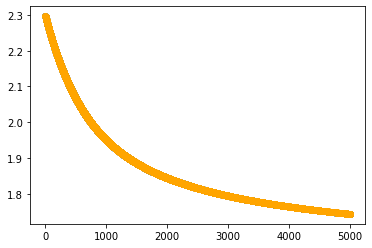

In [91]:
plt.scatter(np.arange(n_iters), gd_total_loss)
plt.scatter(np.arange(n_iters), sp_boost_total_loss, color='orange')
plt.show()

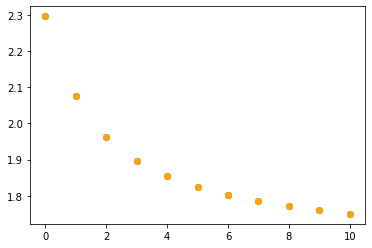

In [100]:
gd_epochs_loss = gd_total_loss[0::q]
sp_boost_epochs_loss = sp_boost_total_loss[0::q]

num_epochs = len(gd_epochs_loss)

plt.scatter(np.arange(num_epochs), gd_epochs_loss)
plt.scatter(np.arange(num_epochs), sp_boost_epochs_loss, color='orange')
plt.show()